In [147]:
# import required libraries

import numpy as np # for easy array operations
import matplotlib.pyplot as plt # for easy visualization
import random # for repeatability

import librosa.display # displaying audio files

import torch
import torch.optim as optim # includes optimization algorithms for training (update parameters of a model in training)
import torch.nn as nn # utilities for neural network layers -- includes Conv2D, MaxPooling, Dense, Flatten, Softmax, etc.
from torch.utils.data import Dataset, DataLoader # 1. create custom dataset 2. loads data for training and evaluation
from torchvision import transforms # for preprocessing data, again, just to transform input dimension

# For repeatability, set random seed to 42.

In [84]:
# set the seed for Python's random module:
random_seed = 42
random.seed(random_seed)

# set the seed for PyTorch:
torch_seed = 42
torch.manual_seed(torch_seed)

# Load GTZAN Dataset (audiofiles)

In [85]:
# deeplake GTZAN dataset citation information:
# @ONLINE {kaggle-diabetic-retinopathy,
#     author = "Kaggle and EyePacs",
#     title  = "Kaggle Diabetic Retinopathy Detection",
#     month  = "jul",
#     year   = "2015",
#     url    = "https://www.kaggle.com/c/diabetic-retinopathy-detection/data"
# }

# GTZAN dataset includes audio tracks recognized into 10 different genres
# each audio track is labeled with genre

# load dataset into python
import deeplake
dataset = deeplake.load("hub://activeloop/gtzan-genre")

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



|

hub://activeloop/gtzan-genre loaded successfully.



# Visualize Data
Check dataset structure. Visualize audiofiles.

In [86]:
# documentation on: https://docs.activeloop.ai/examples/dl/guide/visualizing-datasets
# pip install deeplake[visualizer] for visualize() command

dataset.summary() # tensor layout inspection
print() # empty space for aesthetic
# dataset.visualize() # visualization using an iframe 

Dataset(path='hub://activeloop/gtzan-genre', read_only=True, tensors=['audio', 'genre'])

 tensor      htype              shape             dtype  compression
 -------    -------            -------           -------  ------- 
  audio      audio     (1000, 660000:675808, 1)  float64    wav   
  genre   class_label         (1000, 1)          uint32    None   



# Explanation of structure:
2 Tensors: Audio and Genre

Audio:
- 1000 audio tracks
- 660000 to 675808 (length of each audio track = duration * sample rate) - should all be equal, however differences in recording cause fluctuation
- 1 audio channel (mono)
- currently, the tracks are 22050Hz Mono 16-bit audio files in .wav format.

Genre:
- 1000 class labels
- 1 for each audio track
- data type: unsigned integer 32 bit

# Utility Functions
Ensure that all samples have the same sample rate (samples of audio per second) - needed for consistent CNN inputs.
Normalization of data. Feature extractions into spectrograms.
- for converting audio .wav to mel spectrogram
- for accessing genre name from integer
- for displaying mel spectrogram

In [87]:
# functionality: takes in audio input tensor and computes melspectrogram representation
# sample rate (sr) = 22050 samples per second
# n_fft = number of samples used for each Fourier transform - determines frequency resolution of spectrogram
# hop_length = number of samples between successive frames - time resolution of spectrogram
# n_mels = number of mel frequency bins - determines number of frequency bands in spectrogram

def audio_to_melspectrogram(audio_tensor, sr=22050, n_fft=4096, hop_length=1024, n_mels=256):
    # convert tensor to numpy array (librosa uses numpy instead of torch tensors)
    audio_array = audio_tensor.numpy()

    # compute mel spectrogram - look at comments above function for explanation
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # convert to decibels - for better visualization & normalizing by specifying a reference power level (db converted relative to np.max)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db

# unused:
# # MFCC representation - different representation of audio signal
# def audio_to_mfcc(audio_tensor, sr=22050, n_fft=4096, hop_length=1024, n_mfcc=60):
#     # convert tensor to numpy array
#     audio_array = audio_tensor.numpy()
    
#     # compute mel spectrogram
#     mfcc = librosa.feature.mfcc(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    
#     return mfcc

# maps a genre label (in its integer form) to corresponding genre name
def genre_tensor_to_string(genre):
    # map number to genre name
    number_genre_map = {0:"Pop", 1:"Metal", 2:"Classical", 3:"Rock", 4:"Blues", 5:"Jazz",
                        6:"Hip-hop", 7:"Reggae", 8:"Disco", 9:"Country"}
    
    # convert genre tensor to numpy array
    genre_number = genre.numpy()[0] # access the element

    return number_genre_map[genre_number]

# function to display spectrogram
def plot_spectrogram(spectrogram, genre):
    plt.figure(figsize=(10, 4)) # setup figure: 10 inch height, 4 inch width
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel') # display spectrogram: time vs mel frequency
    plt.colorbar(format='%+2.0f dB') # color bar label for visualization (to show dB scale)
    # label axes
    plt.title(f'Mel Spectrogram of {genre.lower()} song')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # format fitting
    plt.tight_layout()
    # plot!
    plt.show()

# Compute Mel Spectrograms and Genre
For each of the 1000 audio samples, compute and store mel spectrogram images.
Also, convert genre uint32 value to genre string name.

In [89]:
# create list of spectrograms
spectrograms = []

# compute the mel spectrogram for each audio sample
for audio_tensor in dataset["audio"]:
    spectrograms.append(audio_to_melspectrogram(audio_tensor))

# create list of genre labels in string format
genre_labels = []

# convert genre uint32 to string
for genre_tensor in dataset["genre"]:
    genre_labels.append(genre_tensor_to_string(genre_tensor)) # uint32 tensor -> uint32 numpy -> string

# this code cell takes ~2 minutes to compile. ensure you have the correct packages because i installed some more (setuptools and another one, i think)...

# Visualization of Mel Spectrogram
- choose which song to visualize: index 0-999
- it's beautiful

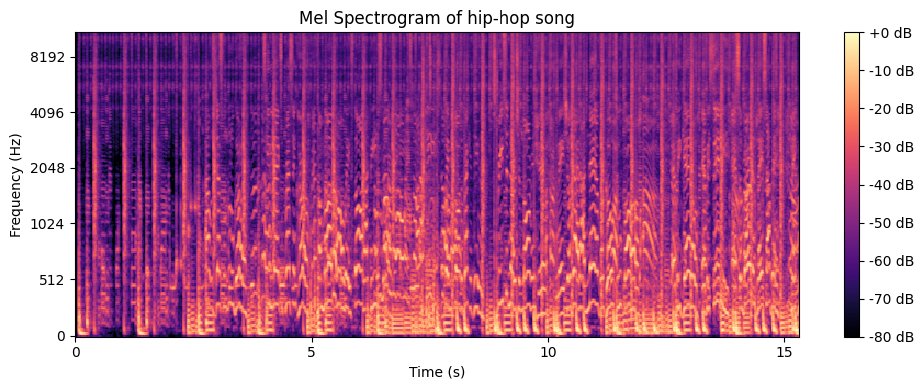

spectrogram shape (256, 660)


In [109]:
index = 645
# pop : 0-99
# metal: 100 - 199
# classical: 200 - 299
# rock: 300 - 399
# blues: 400 - 499
# jazz: 500 - 599
# hip-hop: 600 - 699
# reggae: 700 - 799
# disco: 800 - 899
# country: 900 - 999

plot_spectrogram(spectrograms[index], genre_labels[index])
print('spectrogram shape', spectrograms[index].shape)

# Final Preprocessing Step:
-pad the image to ensure the image is a square

In [121]:
def pad_spectrograms(spectrograms, target_shape=(670,670)):
    padded_spectrograms = []
    for spectrogram in spectrograms:
        current_shape = spectrogram.shape
        pad_height = target_shape[0] - current_shape[0]
        pad_width = target_shape[1] - current_shape[1]

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_spectrogram = np.pad(spectrogram, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
        padded_spectrograms.append(padded_spectrogram)
        
    return padded_spectrograms

In [122]:
# pad spectrograms here
padded_spectrograms = pad_spectrograms(spectrograms)

# Define Dataset Creation Class
First step after preprocessing data - preparing it for input in CNN

In [123]:
# create custom pytorch dataset class to use our PREPROCESSED spectrograms and genre labels
# otherwise, we would be using deeplake's dataset without any modifications

class CustomDataset(Dataset):
    def __init__(self, spectrograms, genre_labels):
        self.spectrograms = spectrograms
        self.genre_labels = genre_labels

    def __len__(self):
        return len(self.spectrograms) # always 1000
    
    def __getitem__(self, index):
        spectrogram = self.spectrograms[index]
        genre_label = self.genre_labels[index]
        return spectrogram, genre_label

# Load Dataset to Computer

In [140]:
preprocessed_dataset = CustomDataset(padded_spectrograms, genre_labels) # create dataset

# calculate size for training and testing split
train_size = int(0.8 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size

print('train_size', train_size) # 800
print('test_size', test_size) # 200

# split dataset into train and test set: 80-20
train_dataset, test_dataset = torch.utils.data.random_split(preprocessed_dataset, [train_size, test_size])

# for loading data, iterating over batches of size 32
batch_size=64
shuffle=False
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

train_size 800
test_size 200


# Define Convolutional Neural Network

In [141]:
class MusicGenreClassifier(nn.Module):
    def __init__(self):
        super(MusicGenreClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # input channels (1 for mono-audio), output channels (16 filters), kernel size = 3x3x3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 16 input (from 16 filters previous), 32 output channels (32 filters)
        # the pooling layer is applied after the first and second conv layers
        self.fc1 = nn.Linear(32 * 167 * 167, 256)  # input size after conv1, maxpool, conv2, maxpool (167 * 167 is the shape)
        self.fc2 = nn.Linear(256, 10) # output: 10 class probabilities (0-9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 167 * 167)  # flatten for FC layers
        x = torch.relu(self.fc1(x))
        x = torch.log_softmax(self.fc2(x), dim=1)  # log softmax for better numerical stability (numbers can get really small)
        return x

# Create an instance of MusicGenreClassifier
Define the loss criterion - cross entropy loss for loss function and Adam optimizer for optimization algorithm

In [142]:
model = MusicGenreClassifier()  # create an instance of the defined model class
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# TRAINING THE MODEL

In [143]:
num_epochs = 10  # number of training epochs

for epoch in range(num_epochs):
    # train loop
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.float() # change datatype from double to float
        
        optimizer.zero_grad()  # zero the gradients
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels) # pass predictions and ground truth to calculate loss

        # backpropogation
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update parameters

        # print statistics after every iteration
        running_loss += loss.item() * inputs.size(0) # the loss for the current batch (our batch size is 32)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 64, 670, 670] to have 1 channels, but got 64 channels instead